In [1]:
#imports 
import astropy.units as u
import numpy as np
import popsims #custom libray for plotting aesthetics
import matplotlib.pyplot as plt
#%matplotlib notebook
from tqdm import tqdm

#import HSS
import seaborn as sns
import matplotlib as mpl

import astropy.coordinates as astro_coord
import glob
import pandas as pd
#sns.set_style("dark")
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 
font = {'axes.titlesize'      : 'large',   # fontsize of the axes title
        'axes.labelsize'      : 'large', # fontsize of the x any y labels
        'size'   : 20}


import itertools
from scipy import stats
from shapey import Box
#paths
path_plot = '/users/caganze/research/stellarstreams/figures/paper/'
#path_data = '/users/caganze/research/stellarstreams/data/rotating/'
path_data = '/users/caganze/research/stellarstreams/data/stream/'
isochrone_path='/users/caganze/research/stellarstreams/data/isochrones/'
from sklearn.preprocessing import MinMaxScaler

In [2]:
#increase precision
np.set_printoptions(precision=10)

In [3]:
#get some cutout   
def draw_box(center, xextent, yextent, color='r'):
    b=Box()
    x_min, x_max =center[0]- xextent/2, center[0]+ xextent/2
    y_min, y_max =center[-1]- yextent/2, center[-1]+ yextent/2
    v1= (x_min, y_min)
    v2=(x_min, y_max)
    v4= (x_max, y_min)
    v3=(x_max,y_max)

    b.vertices=[v1, v2, v3, v4, v1]
    b.color='none'
    b.edgecolor=color
    return b

def get_cutout_m31(rgc, mhalo, mag_limit):
    filename=path_data+'gaps_at_M31{} mlimit {}Mhalo={:.2e}_cutout'.format(rgc, mag_limit, mhalo )
    return pd.read_csv(filename).values
                       
    
def get_cutout_distance(mhalo, mag_limit, dmod):
    filename=path_data+'/gaps_at_OTHER{}Mhalo={:.2e}_maglimit{}_cutout.txt'.format(dmod, mhalo, mag_limit)
    return pd.read_csv(filename).values

def compute_box_stas(data):
    #return surface density and center of the box 
    cent= np.nanmedian(data, axis=1)
    #compute size of the box
    bx_size= np.ptp(data, axis=1)
    dens= len(data[0])/(np.nansum(bx_size**2))**0.5
    
    return cent, dens

def boostrap_density_estimate(gapper_base, bw, grid_data, data, bounds, nboostrap, max_eigenvalue=True):
    ##purpose: with a gapper object, 
    #we can estimate the hessian and the maximum eigevalue by boostrapping the data
    PiHPi_boots=[]
    maxeigval_PiHPi_boots =[]
    
    #loop over all bootstraps
    for i in range(nboostrap):
        boot_indx = np.random.choice(np.arange(data.shape[0]), data.shape[0], 
                                     replace=True) ## Sample with replacement:bootstrap

        gapper_ = Gapper(data[boot_indx], bw, bounds)
        PiHPis_grid = []
        eigval_PiHPi = [] 

        for pt in grid_data:
            _pihpi = gapper_.get_PiHPi(pt) 
            _pihpi_eigval, _pihpi_eigvec = np.linalg.eigh(_pihpi)

            PiHPis_grid.append(_pihpi)
            eigval_PiHPi.append(_pihpi_eigval)

        PiHPis_grid, eigval_PiHPi = np.array(PiHPis_grid), np.array(eigval_PiHPi)
        
        #option for using minium or maximum eigenvalue
        if max_eigenvalue:
            max_eigval_PiHPi_k = np.max(eigval_PiHPi, axis=1)

        if not max_eigenvalue:
            max_eigval_PiHPi_k = np.min(eigval_PiHPi, axis=1)

        maxeigval_PiHPi_boots.append(max_eigval_PiHPi_k)

        PiHPi_boots.append(PiHPis_grid)
        print(f'Run {i} finished')
        
    return np.array(maxeigval_PiHPi_boots), np.array(PiHPi_boots)
            
        

def detect_gap_by_boostrap(bws, data, xlims, ylims, rescale=False, \
                           max_eigenvalue=True, nboostrap=3):
    
    """
    Purpose detect gap by bootstrapping and using an median over several bandwidths
    
    """

    res=dict(zip(bws, [None for x in bws]))
    
    density_matr=None

    for bw in bws: #option for doing this over multiple bandwidths
        #option for rescaling 
        min_bw_x= 0.05
        min_bw_y= 0.05
        #min_bw_x= bw/10
        #min_bw_y= bw/10

        #Boundaries for the Gapper (if none are provided, this is the default mode)
        bounds = np.array([[np.min(data[:,d]),np.max(data[:,d])] for d in range(data.shape[1])])

        gridding_size = [ int((xlims[1]-xlims[0])/min_bw_x), int((ylims[1]-ylims[0])/min_bw_y)]

        grid_linspace = [ np.linspace(bounds[d][0], bounds[d][1], gridding_size[d]) for d in range(2) ]
        #could use a rectangular grid instead

        meshgrid = np.meshgrid(*grid_linspace, indexing='ij')

        meshgrid_ravel = [ xi.ravel().reshape(-1,1) for xi in meshgrid]
        grid_data = np.hstack(meshgrid_ravel)

        if rescale:
            #fit the grid using
            minmaxscal = MinMaxScaler().fit(data)
            #get transformed data and grid
            data_resc = minmaxscal.transform(data)
            grid_data_resc = minmaxscal.transform(grid_data)
            #compute new bounds
            bounds = np.array([[np.min(data_resc[:,d]),np.max(data_resc[:,d])] for d in range(data_resc.shape[1])])
            
            #estimate density a
            #rescale the bandwidth by the change from previous data to rescaled data
            scale=np.ptp(data_resc[:,0])/ np.ptp(data[:,0])
            gapper_base = Gapper(data_resc, bw*scale, bounds)
            grid_density = gapper_base.kde.score_samples(torch.tensor(grid_data_resc))
            density_matr = grid_density.reshape((gridding_size[0], gridding_size[1]))
            
            #estimate hessian by bootstrapping
            maxeigval_PiHPi_boots, PiHPi_boots = boostrap_density_estimate(gapper_base, bw*scale,\
                                                                           grid_data_resc, data_resc, bounds, \
                                                                           nboostrap,\
                                                                           max_eigenvalue=max_eigenvalue)
            data=data_resc
            
        if not rescale:
            gapper_base = Gapper(data, bw, bounds)
            #compute density along the grid 
            grid_density = gapper_base.kde.score_samples(torch.tensor(grid_data))

            #density matrix 
            density_matr = grid_density.reshape((gridding_size[0], gridding_size[1]))

            #compute piHpi matrix by bootstraping
            maxeigval_PiHPi_boots, PiHPi_boots = boostrap_density_estimate(gapper_base, bw,\
                                                                           grid_data, data, bounds, nboostrap,\
                                                                           max_eigenvalue=max_eigenvalue)
     
        #visualize and take the median
        maxeigval_PiHPi_boots = np.array(maxeigval_PiHPi_boots)
        print(maxeigval_PiHPi_boots.shape)

        #median
        med_maxeigval_pihpi = np.median(maxeigval_PiHPi_boots, axis=0)


        med_maxeigval_pihpi_resh = med_maxeigval_pihpi.reshape((gridding_size[0], gridding_size[1]))


        res[bw]= {'density':density_matr, \
                  'max_eigen':med_maxeigval_pihpi_resh,
                  'meshgrid':meshgrid, 
                  'PiHPi': PiHPi_boots,
                  'data': data}

    return res
    

In [4]:
mhalo=5e6
mag_limit=28.54

In [5]:
data=get_cutout_m31('50_60', mhalo, mag_limit)

In [6]:
from scipy import stats

In [7]:
from findthegap.gapper import Gapper
import torch

In [8]:
#use gabby's gap detector to find the gap independent of box size
size_stream=0.2
size_gap=0.8
res_gap= detect_gap_by_boostrap([size_gap],data, [data[:,0].min(), \
                                                                data[:,0].max()],\
                                [data[:,1].min(), data[:,1].max()], rescale=True)
res_stream=  detect_gap_by_boostrap([size_stream],data, [data[:,0].min(), \
                                                                data[:,0].max()],\
                                [data[:,1].min(), data[:,1].max()], max_eigenvalue=False, rescale=True)

Run 0 finished
Run 1 finished
Run 2 finished
(3, 4031)
Run 0 finished
Run 1 finished
Run 2 finished
(3, 4031)


In [9]:
(data[:,0].min()-data[:,0].max())/0.05

-139.5431469417676

In [10]:
size_stream, size_gap

(0.2, 0.8)

In [11]:
(data[:,1].min()-data[:,1].max())/0.05

-29.98208344463592

In [12]:
res= {**res_gap, **res_stream}

In [13]:
res[size_gap].keys()

dict_keys(['density', 'max_eigen', 'meshgrid', 'PiHPi', 'data'])

In [14]:
#pick the 99 percentile
threshold = np.percentile(res[size_gap]['max_eigen'], 97) 
gap_mask = res[size_gap]['max_eigen'] > threshold

meshgrid_ravel = [ xi.ravel().reshape(-1,1) for xi in  res[size_gap]['meshgrid']]
grid_data = np.hstack(meshgrid_ravel)

In [15]:
np.shape(grid_data), np.shape(data)

((4031, 2), (2802, 2))

/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_11656/3537184275.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 
/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_11656/3537184275.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(path_plot+'

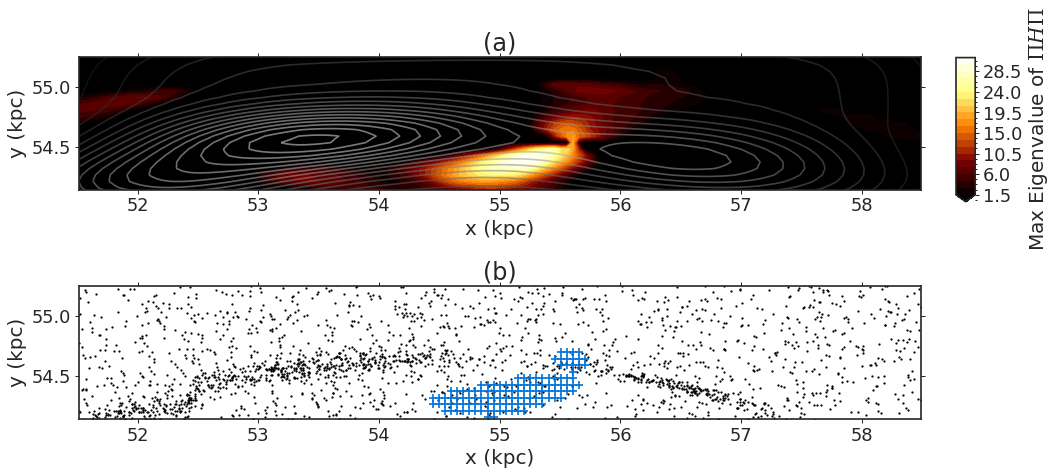

In [16]:


fig, (ax, ax1)=plt.subplots(figsize=(12, 6), nrows=2, sharex=True)

meshgrid= res[size_gap]['meshgrid']

ax.contour(meshgrid[0], meshgrid[1],  res[size_gap]['density'],  20, \
                  cmap='Greys_r', alpha=.5)

cax = fig.add_axes([1.01, 0.6, .02, 0.3])
p= ax.contourf(meshgrid[0], meshgrid[1], res[size_gap]['max_eigen'],\
                        20, cmap='afmhot',  extend='min')
plt.colorbar(p, label=r'Max Eigenvalue of $\Pi H \Pi$', ax=ax, cax=cax)
ax.set(xlabel='x (kpc)', ylabel='y (kpc)', title='(a)')
plt.minorticks_on()

ax1.scatter(data[:,0], data[:,1], s=1, c='k')
ax1.scatter(grid_data[:,0][gap_mask.flatten().astype(bool)], \
            grid_data[:,1][gap_mask.flatten().astype(bool)], s=50,\
            marker='+', c='#0074D9')

ax1.set(xlabel='x (kpc)', ylabel='y (kpc)', title='(b)',  ylim=[data[:,1].min(), data[:,1].max()])
ax.tick_params(labelbottom=True)
plt.tight_layout()
ax.axis('equal')
ax1.axis('equal')
plt.savefig(path_plot+'/stream_cutout_gap.jpeg'.format(mag_limit, mhalo), rasterized=True,\
            bbox_inches='tight')


In [17]:
gap_loc=(np.nanmean(grid_data[:,0][gap_mask.flatten().astype(bool)]), \
        np.nanmean(grid_data[:,1][gap_mask.flatten().astype(bool)]))
gap_size=np.nanstd(data[:,0][gap_mask.flatten().astype(int)])

In [18]:
gap_loc

(55.12649540977531, 54.37641783477204)

In [19]:
len

<function len(obj, /)>

In [20]:
#pick the 99 percentile
threshold = np.percentile(res[size_stream]['max_eigen'], 1) 
stream_mask= (res[size_stream]['max_eigen'] <threshold).flatten()

/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_11656/3456987388.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_11656/3456987388.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(path_plot+'/stream_cutout_stream.jpeg'.format(mag_limit, mhalo), rasterized=True, \


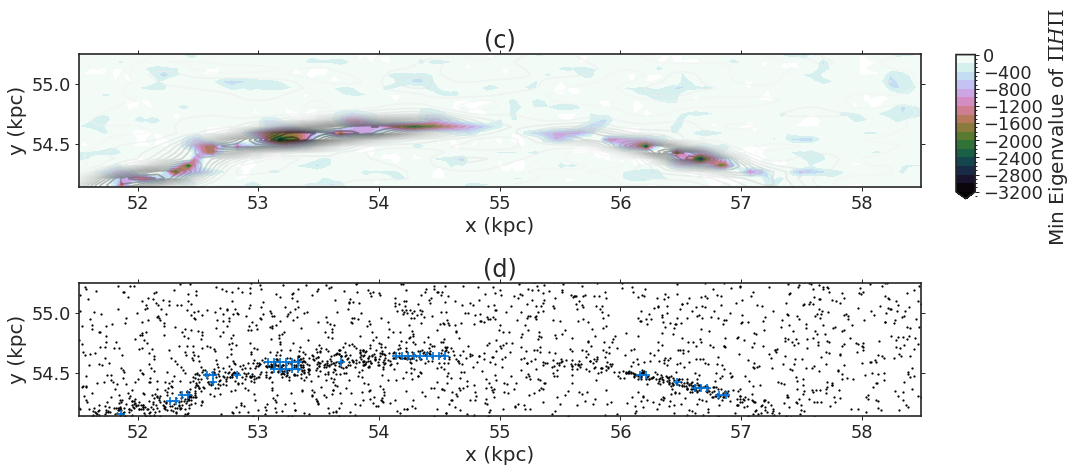

In [21]:

fig, (ax, ax1)=plt.subplots(figsize=(12, 6), nrows=2, sharex=True)

meshgrid= res[size_gap]['meshgrid']

ax.contour(meshgrid[0], meshgrid[1],  res[size_stream]['density'],  20, \
                  cmap='Greys', alpha=.5)

cax = fig.add_axes([1.01, 0.6, .02, 0.3])
p= ax.contourf(meshgrid[0], meshgrid[1], res[size_stream]['max_eigen'],\
                        20, cmap='cubehelix',  extend='min')
plt.colorbar(p, label=r'Min Eigenvalue of $\Pi H \Pi$', ax=ax, cax=cax)
ax.set(xlabel='x (kpc)', ylabel='y (kpc)', title='(c)')
plt.minorticks_on()

ax1.scatter(data[:,0], data[:,1], s=1, c='k')
ax1.scatter(grid_data[:,0][stream_mask.flatten().astype(bool)], \
            grid_data[:,1][stream_mask.flatten().astype(bool)], s=50, marker='+', c='#0074D9')

ax1.set(xlabel='x (kpc)', ylabel='y (kpc)', title='(d)', ylim=[data[:,1].min(), data[:,1].max()])
ax.tick_params(labelbottom=True)
plt.tight_layout()
ax.axis('equal')
ax1.axis('equal')
plt.savefig(path_plot+'/stream_cutout_stream.jpeg'.format(mag_limit, mhalo), rasterized=True, \
            bbox_inches='tight')


In [22]:
#fitting a polynomial to the stream and the background
# we already have an estimate on the polynomial bandwidth
#figure which stars belong to the gap

x=grid_data[:,0][stream_mask.flatten().astype(bool)]
y=grid_data[:,1][stream_mask.flatten().astype(bool)]
x[-1]=gap_loc[0]
y[-1]=gap_loc[1]
pol= np.poly1d(np.polyfit(x, y, 2))



In [23]:
#compute the density along the line
stream_density_along_grid =[]
stream_density_out =[]
xdiff= gap_size
grid=np.arange(data[:,0].min(), data[:,0].max(), xdiff)
for g in grid:
    mask= np.logical_and.reduce([data[:,1]> pol(g)-size_stream,\
                                data[:,1]< pol(g)+size_stream, 
                                data[:,0] >= g,
                                data[:,0] <g+xdiff])
    
    mask2= np.logical_and.reduce([data[:,1]> pol(g)+0.5-size_stream,\
                                data[:,1]< pol(g)+0.5+size_stream, 
                                data[:,0] >= g,
                                data[:,0] <g+xdiff])
    
    stream_density_along_grid.append(len(data[:,1][mask]))
    
    stream_density_out.append(len(data[:,1][mask2]))
    
    

/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_11656/591788609.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(path_plot+'/stream_cutout_fit.jpeg'.format(mag_limit, mhalo), rasterized=True)


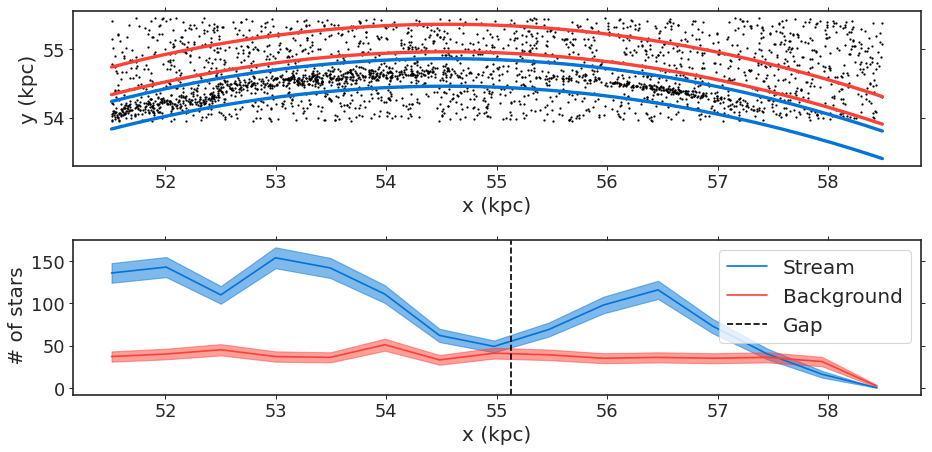

In [24]:
fig, (ax, ax1)=plt.subplots(figsize=(12, 6), nrows=2, sharex=True)

ax.scatter(data[:,0], data[:,1], s=1, c='k')
#ax.plot(grid_data[:,0], pol(grid_data[:,0]), linewidth=3, c='b')
ax.plot(grid_data[:,0], pol(grid_data[:,0])-size_stream, linewidth=3, c='#0074D9')
ax.plot(grid_data[:,0], pol(grid_data[:,0])+size_stream, linewidth=3, c='#0074D9')

#ax.plot(grid_data[:,0], pol(grid_data[:,0])+0.5, linewidth=3, c='r')
ax.plot(grid_data[:,0], pol(grid_data[:,0])+0.5-size_stream, linewidth=3, c='#FF4136')
ax.plot(grid_data[:,0], pol(grid_data[:,0])+0.5+size_stream, linewidth=3, c='#FF4136')

ax.set(xlabel='x (kpc)', ylabel='y (kpc)')

ax.tick_params(labelbottom=True)

plt.tight_layout()

ax1.plot(grid, stream_density_along_grid, label='Stream', color='#0074D9' )
ax1.fill_between(grid, stream_density_along_grid-np.sqrt(stream_density_along_grid),  
              stream_density_along_grid+np.sqrt(stream_density_along_grid), alpha=0.5, color='#0074D9')
ax1.plot(grid, stream_density_out , alpha=1, label='Background' , color='#FF4136')
ax1.fill_between(grid, stream_density_out-np.sqrt(stream_density_out),
                stream_density_out+np.sqrt(stream_density_out),
                alpha=0.5, color='#FF4136')
ax1.set(ylabel=' # of stars', xlabel='x (kpc)')
ax1.axvline(gap_loc[0], c='k', linestyle='--', label='Gap')
plt.legend()
plt.tight_layout()
plt.savefig(path_plot+'/stream_cutout_fit.jpeg'.format(mag_limit, mhalo), rasterized=True)

In [25]:
np.nanmedian(stream_density_along_grid )

98.0

In [26]:
np.nanmedian(stream_density_out)

36.0

In [27]:
#figure out the number of stars in the gap
gap_stars= len(data[:,0][np.logical_and.reduce([data[:,1]> pol(gap_loc[0])-size_stream,\
                                data[:,1]< pol(gap_loc[0])+size_stream, 
                                data[:,0] >= gap_loc[0],
                                data[:,0] <gap_loc[0]+xdiff])])

In [28]:
gap_stars

58

In [29]:
#average number of stars along in the background
st= stats.gamma.rvs(np.nanmedian(stream_density_along_grid ), size =int(1e5))
bckg=  stats.gamma.rvs(np.nanmedian(stream_density_out), size =int(1e5))
gap=stats.gamma.rvs(gap_stars, size =int(1e5))

/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_11656/4149646425.py:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(path_plot+'/histograms_poisson.jpeg'.format(mag_limit, mhalo), rasterized=True)


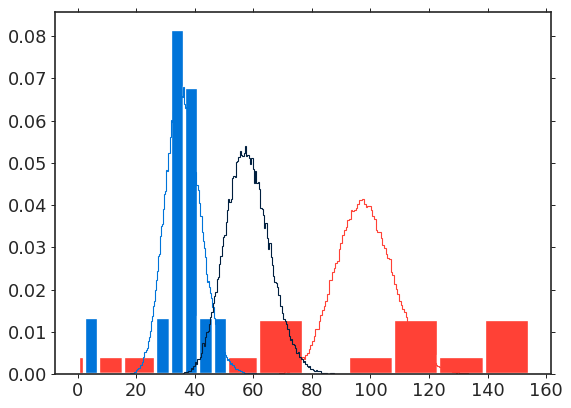

In [30]:
fig, ax=plt.subplots()
_= ax.hist( stream_density_along_grid, cumulative=False, linewidth=3, density=True,  color='#FF4136')
_= ax.hist( stream_density_out, cumulative=False, linewidth=3, density=True,   color='#0074D9')

_ = ax.hist(st,  histtype='step', density=True,  color='#FF4136', bins='auto')
_ = ax.hist(bckg, histtype='step', density=True,  color='#0074D9', bins='auto')
_ = ax.hist(gap, histtype='step', density=True,  color='#001f3f', bins='auto')
plt.savefig(path_plot+'/histograms_poisson.jpeg'.format(mag_limit, mhalo), rasterized=True)

In [31]:
#pick the 99 percentile
threshold = np.percentile(res[size_stream]['max_eigen'], 1) 
stream_mask= ~(res[size_stream]['max_eigen'] <threshold).flatten()

In [32]:
masked_dens= np.ma.array(np.array(res[size_stream]['density']), mask=stream_mask)
masked_dens_out= np.ma.array(np.array(res[size_stream]['density']), mask=~stream_mask)

/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_11656/851374210.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_11656/851374210.py:22: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(path_plot+'/stream_cutout_fit_density.jpeg'.format(mag_limit, mhalo), \


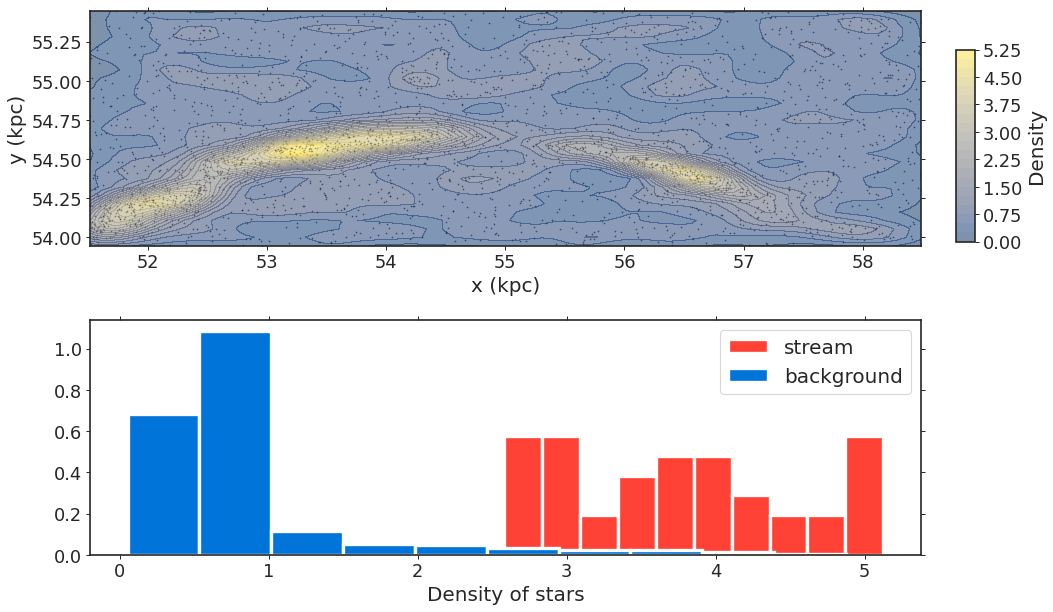

In [33]:

fig, (ax, ax1)=plt.subplots(figsize=(12, 8), nrows=2)

ax.scatter(data[:,0], data[:,1], s=.1, c='k')
c=ax.contourf( meshgrid[0], meshgrid[1], np.array(res[size_stream]['density']),  20, \
                  cmap='cividis', alpha=.5)

cax = fig.add_axes([1.01, 0.6, .02, 0.3])
plt.colorbar(c, label='Density', ax=ax, cax=cax)
ax.set(xlabel='x (kpc)', ylabel='y (kpc)')


_= ax1.hist( masked_dens.compressed(), cumulative=False, linewidth=3, density=True,  \
           color='#FF4136', label='stream')
_= ax1.hist( masked_dens_out.compressed(), cumulative=False, linewidth=3, density=True,  color='#0074D9',\
           label='background')

#ax.axvline(np.nanmedian(masked_dens.compressed()))
ax1.set(xlabel='Density of stars')

ax1.legend()
plt.tight_layout()
plt.savefig(path_plot+'/stream_cutout_fit_density.jpeg'.format(mag_limit, mhalo), \
            rasterized=True, bbox_inches='tight')

In [34]:
np.min(data[:,1])-np.max(data[:,1]), np.min(data[:,0])-np.max(data[:,0])

(-1.499104172231796, -6.977157347088379)

7.49552086115898 9.967367638697686
(2802, 2)


(array([0.6813749548, 1.0831317079, 0.1169407745, 0.0514539408,
        0.0457368476, 0.0337828904, 0.0218289446, 0.0213092183,
        0.0135131562, 0.004677631 ]),
 array([0.05314782, 0.53536606, 1.0175842 , 1.4998025 , 1.9820207 ,
        2.464239  , 2.9464571 , 3.4286754 , 3.9108934 , 4.3931117 ,
        4.87533   ], dtype=float32),
 <BarContainer object of 10 artists>)

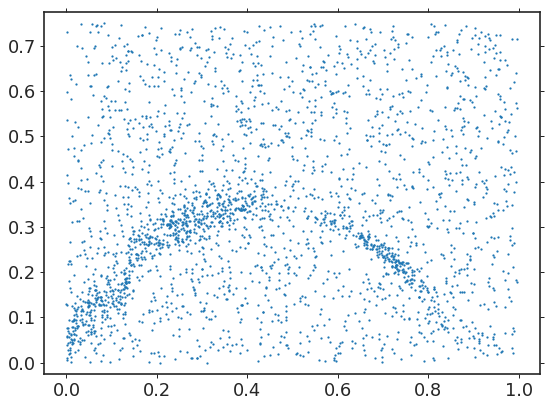

In [35]:
#try scaling things using 2 methods,
#rescale then use unatural units

target_u = 0.1## <= "target_unit", arbitraty value but the bandwidth you'll use? or twice the bandwidth?
## see below, apparently twice the bw.. not sure i understand why... but the plots look best doing this...

exp_width_y = 0.2  ## fake stream width is expected .2
exp_width_x = 0.7 ## Fake gap width is expected .7 
## As we discussed, if you don't want to span accross search, just say you make assumption / present protocols for
## specific gap sizes to some extend? We can think how to combine runs with multiple / various gap sizes later...

## Convoluted way of doing the rescaling but that's how i understand it:
## Get "how many expected_width" you can put in each dimension in the data-range
Ny = (np.max(data[:,1]) - np.min(data[:,1]))/exp_width_y
Nx = (np.max(data[:,0]) - np.min(data[:,0]))/exp_width_x
print(Ny, Nx)

## Your new data-space should range from (0, (number of expected widths) * target_unit)
## So (0, b_x) / ( 0, b_y) respectively
b_y = Ny * target_u
b_x = Nx * target_u

## This does the actual rescaling to (0, b) in each dimension
data_resc_y = ((data[:,1] - np.min(data[:,1]))*b_y)/(np.max(data[:,1]) - np.min(data[:,1]))
data_resc_x = ((data[:,0] - np.min(data[:,0]))*b_x)/(np.max(data[:,0]) - np.min(data[:,0]))
data_resc = np.stack([data_resc_x, data_resc_y],axis=1)
print(data_resc.shape)

fig, ax=plt.subplots()
plt.scatter(data_resc[:,0], data_resc[:,1], s=1)
ax.axis('equal')
_## Now one target_u = .2 in y = .7 in x in the original space. (I think?)

In [36]:
bounds = np.array([[np.min(data_resc[:,d]),np.max(data_resc[:,d])] for d in range(data_resc.shape[1])])

## Do we still want to grid more finely on x than y with the rescaling? Maybe we don't need anymore? idk
gridding_size = [int(Nx)*10, int(Ny)*10]
grid_linspace = [ np.linspace(bounds[d][0], bounds[d][1], gridding_size[d]) for d in range(2) ]

meshgrid = np.meshgrid(*grid_linspace, indexing='ij')

meshgrid_ravel = [ xi.ravel().reshape(-1,1) for xi in meshgrid]
grid_data = np.hstack(meshgrid_ravel)

In [37]:
## Get the density estimates etc etc

bw = target_u  ### <= so. I need to wrap my mind around this but, need to work on bw < target_u. 
## target_u / 2. also looked alrightish?

gapper_ = Gapper(data_resc, bw, bounds)

grid_density = gapper_.kde.score_samples(torch.tensor(grid_data))
density_matr = grid_density.reshape((gridding_size[0], gridding_size[1]))
PiHPis_grid = []
eigval_PiHPi = [] 

for pt in grid_data:
    _pihpi = gapper_.get_PiHPi(pt) 
    _pihpi_eigval, _pihpi_eigvec = np.linalg.eigh(_pihpi)

    PiHPis_grid.append(_pihpi)
    eigval_PiHPi.append(_pihpi_eigval)
PiHPis_grid, eigval_PiHPi = np.array(PiHPis_grid), np.array(eigval_PiHPi)
max_eigval_PiHPi = np.max(eigval_PiHPi, axis=1)
max_eigval_PiHPi_resh = max_eigval_PiHPi.reshape((gridding_size[0], gridding_size[1]))


In [38]:
#for posters
#plt.style.use('dark_background')

/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_11656/1134219610.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(path_plot+'/stream_cutout_gap_scaled.jpeg', rasterized=True,\


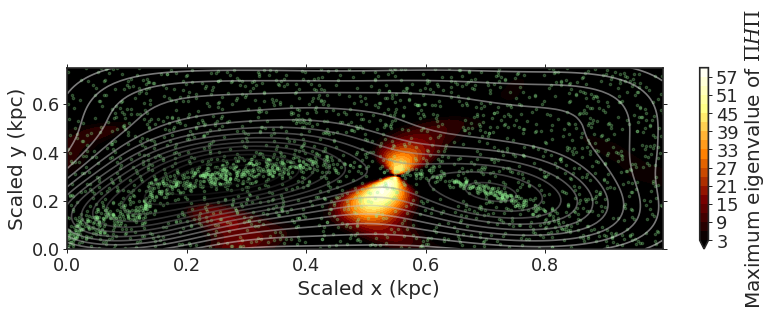

In [39]:
fig, ax=plt.subplots(figsize=(12, 3))
pi = ax.contourf(meshgrid[0], meshgrid[1], max_eigval_PiHPi_resh, 20, cmap='afmhot', extend='min')
ax.contour(meshgrid[0], meshgrid[1], density_matr, 20, cmap='Greys', alpha=.5)

ax.scatter(data_resc[:,0], data_resc[:,1], s=5, c='lightgreen', alpha=.25)

cb = plt.colorbar(pi, label=f"Maximum eigenvalue of $\Pi H \Pi$ ")

#ax.axis('equal')
#ax.axis('equal')
ax.set(xlabel =' Scaled x (kpc)', ylabel='Scaled y (kpc)')
plt.savefig(path_plot+'/stream_cutout_gap_scaled.jpeg', rasterized=True,\
            bbox_inches='tight')